In [147]:
%load_ext autoreload
%autoreload 2
import hippo
import mrich
from mrich import print
from mocassin.mocassin import calculate_mocassin_tversky
from os import environ
from pathlib import Path
from itertools import product, combinations
import pandas as pd
from rdkit.Chem import AllChem
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import rankdata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
animal = hippo.HIPPO("A71EV2A_mocassin",Path(environ["BULK"]) / "TARGETS/A71EV2A_2/A71EV2A_2.sqlite")

 Creating HIPPO animal

name = A71EV2A_mocassin

db_path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/A71EV2A_2/A71EV2A_2.sqlite

DEBUG: hippo.Database.__init__()

DEBUG: Database.path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/A71EV2A_2/A71EV2A_2.sqlite

DEBUG: hippo.Database.connect()

DEBUG: sqlite3.version='2.6.0'

 Success  Database connected @ /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/A71EV2A_2/A71EV2A_2.sqlite!

 Success  Initialised animal HIPPO("A71EV2A_mocassin")!

In [5]:
animal.add_hits(
    "A71EV2A", 
    Path(environ["BULK"]) / "TARGETS/A71EV2A/metadata.csv",
    Path(environ["BULK"]) / "TARGETS/A71EV2A/aligned_files",
)

aligned_directory = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/A71EV2A/aligned_files

curated_tag_cols =
[
    '[Other] upload_4 2025-04-02',
    '[Other] Lactam Series',
    '[Other] upload_2 2025-02-28',
    '[Other] cyclopropane',
    '[Other] upload_1 2025-02-12',
    '[Other] fff_i1_design',
    '[Other] New',
    '[Other] P2 Wave 1',
    '[Other] Active site fragment',
    '[Other] upload_6_2025-02-13',
    '[Other] S2 site',
    '[Other] Fragment Screen',
    '[Other] Bogyo covalents',
    '[Other] Covalent',
    '[Other] upload_1 2024-12-06',
    '[Series] Indazole series',
    '[Other] upload_061224',
    '[Other] upload_5 2025-02-03',
    '[Other] upload_3 2024-12-19',
    '[Other] upload_4 2025-01-06',
    '[Other] S3 site',
    '[Other] S4 site',
    '[Other] S5 site',
    '[Other] Sun-roof open',
    '[Other] upload_2 2024-12-12',
    '[Other] S1 site',
    "[Other] S1' site",
    '[Series] Piperidine series',
    '[Other] upload_3 2025-03-06',
    '[Other] P3 compound design',
    '[Other] upload_5 2025-04-10'
]

Output()

Warning: Unknown residue type for HOHC. Defaulted to LIG

Warning: Unknown residue type for HOHF. Defaulted to LIG

Warning: Unknown residue type for GOL. Defaulted to LIG

#directories parsed = 645

#compounds registered = 457

#poses registered = 645

In [69]:
frags = animal.poses(tag="[Other] Fragment Screen").get_by_tag("[Other] Active site fragment")
leads = animal.poses(tag="[Other] P3 compound design")
frags, leads

({P × 43},
 poses tagged "[Other] P3 compound design": {P × 519})

In [39]:
frag_lookup = {p.id:p for p in frags}
lead_lookup = {p.id:p for p in leads}

In [40]:
single_combinations = list(product(frags.ids, leads.ids))
print(len(single_combinations))

double_combinations = list(product(combinations(frags.ids, 2), leads.ids))
print(len(double_combinations))

22317

468657

In [41]:
%%time
data = []
for frag_id, lead_id in mrich.track(single_combinations):
    frag = frag_lookup[frag_id]
    lead = lead_lookup[lead_id]
    d = dict(
        lead_id=lead_id,
        lead_alias=lead.alias,
        lead_mol=lead.mol,
        frag_ids=[frag_id],
        frag_aliases=[frag.alias],
        frag_mols=[frag.mol],
    )
    data.append(d)

Output()

CPU times: user 513 ms, sys: 3.06 ms, total: 516 ms
Wall time: 509 ms


In [42]:
%%time
for frag_ids, lead_id in mrich.track(double_combinations):
    lead = lead_lookup[lead_id]

    frags = [frag_lookup[i] for i in frag_ids]
    
    d = dict(
        lead_id=lead_id,
        lead_alias=lead.alias,
        lead_mol=lead.mol,
        frag_ids=list(frag_ids),
        frag_aliases=[p.alias for p in frags],
        frag_mols=[p.mol for p in frags],
    )
    data.append(d)

Output()

CPU times: user 5.01 s, sys: 47.2 ms, total: 5.06 s
Wall time: 4.95 s


In [43]:
df = pd.DataFrame(data)
df.head()

lead_id lead_alias                                          lead_mol  \
0        1     A5666a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f619c9f0>   
1        2     A4298a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f61a4540>   
2        3     A4918a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f61a5080>   
3        4     A5151a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f61a54e0>   
4      126     A2290a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f61a5300>   

  frag_ids frag_aliases                                          frag_mols  
0      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...  
1      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...  
2      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...  
3      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...  
4      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...

In [44]:
df.to_pickle("A71EV2A_active_single_and_double_raw.pkl.gz")

In [73]:
%%time
n = len(df)
# lookup_count = 0
skip_count = 0
for j,(i,row) in mrich.track(enumerate(df.iterrows()), total=n):

    mrich.set_progress_field("j", j)
    mrich.set_progress_field("n", n)
    mrich.set_progress_field("skip", skip_count)
    # mrich.set_progress_field("lookup", lookup_count)

    key = (row["lead_id"], tuple(row["frag_ids"]))

    if pd.notna(row["mocassin b-c/b"]):
        skip_count += 1
        continue

    # elif key in lookup:

    #     ref = lookup[key]

    #     df.loc[i, "mocassin_combo(0.95,0.05)"] = ref["mocassin_combo(0.95,0.05)"]
    #     df.loc[i, "mocassin_shape(0.95,0.05)"] = ref["mocassin_shape(0.95,0.05)"]
    #     df.loc[i, "mocassin_colour(0.95,0.05)"] = ref["mocassin_colour(0.95,0.05)"]
    #     df.loc[i, "mocassin a"] = ref["mocassin a"]
    #     df.loc[i, "mocassin b"] = ref["mocassin b"]
    #     df.loc[i, "mocassin c"] = ref["mocassin c"]
    #     df.loc[i, "mocassin a-c"] = ref["mocassin a-c"]
    #     df.loc[i, "mocassin b-c"] = ref["mocassin b-c"]
    #     df.loc[i, "mocassin a-c/a"] = ref["mocassin a-c/a"]
    #     df.loc[i, "mocassin b-c/b"] = ref["mocassin b-c/b"]

    #     lookup_count += 1
        
    try:
        combo, shape, colour, a, b, c = calculate_mocassin_tversky(
            row["frag_mols"],
            row["lead_mol"],
            alpha=0.95,
            beta=0.05,
        )
        df.loc[i, "mocassin_combo(0.95,0.05)"] = combo
        df.loc[i, "mocassin_shape(0.95,0.05)"] = shape
        df.loc[i, "mocassin_colour(0.95,0.05)"] = colour
        df.loc[i, "mocassin a"] = a
        df.loc[i, "mocassin b"] = b
        df.loc[i, "mocassin c"] = c
        df.loc[i, "mocassin a-c"] = a-c
        df.loc[i, "mocassin b-c"] = b-c
        df.loc[i, "mocassin a-c/a"] = (a-c)/a
        df.loc[i, "mocassin b-c/b"] = (b-c)/b
        # print(combo, shape, colour, a, b, c)

    except Exception as e:
        mrich.error(e)


Output()

CPU times: user 26min 21s, sys: 25.2 s, total: 26min 46s
Wall time: 26min 50s


In [84]:
df["frag_ids"] = df["frag_ids"].apply(tuple)

In [85]:
df = df.drop_duplicates(subset=["lead_id", "frag_ids"])

In [74]:
df.to_pickle("A71EV2A_active_single_and_double_mocassin.pkl.gz")

In [46]:
df2 = pd.read_pickle("A71EV2A_single_and_double_mocassin.pkl.gz")

In [51]:
subset = df[(df["lead_id"] == 1) & (df["frag_ids"].apply(lambda x: x == [5]))]
subset

lead_id lead_alias                                          lead_mol  \
0        1     A5666a  <rdkit.Chem.rdchem.Mol object at 0x7fd8f619c9f0>   

  frag_ids frag_aliases                                          frag_mols  \
0      [5]     [A0450a]  [<rdkit.Chem.rdchem.Mol object at 0x7fd8f619ec...   

   mocassin_combo(0.95,0.05)  mocassin_shape(0.95,0.05)  \
0                      0.373                      0.723   

   mocassin_colour(0.95,0.05)  mocassin a  mocassin b  mocassin c  \
0                       0.023         4.0         7.0    0.096027   

   mocassin a-c  mocassin b-c  mocassin a-c/a  mocassin b-c/b  
0      3.903973      6.903973        0.975993        0.986282

In [72]:
frag_ids = set(frags.ids)
lead_ids = set(leads.ids)

n = len(df2)
for i,row in mrich.track(df2.iterrows(), total=n):
    mrich.set_progress_field("i", i)
    mrich.set_progress_field("n", n)
    key = (row["lead_id"], tuple(row["frag_ids"]))

    if row["lead_id"] in lead_ids:
        if all(i in frag_ids for i in row["frag_ids"]):

            i = lookup[key]
            
            df.loc[i, "mocassin_combo(0.95,0.05)"] = row["mocassin_combo(0.95,0.05)"]
            df.loc[i, "mocassin_shape(0.95,0.05)"] = row["mocassin_shape(0.95,0.05)"]
            df.loc[i, "mocassin_colour(0.95,0.05)"] = row["mocassin_colour(0.95,0.05)"]
            df.loc[i, "mocassin a"] = row["mocassin a"]
            df.loc[i, "mocassin b"] = row["mocassin b"]
            df.loc[i, "mocassin c"] = row["mocassin c"]
            df.loc[i, "mocassin a-c"] = row["mocassin a-c"]
            df.loc[i, "mocassin b-c"] = row["mocassin b-c"]
            df.loc[i, "mocassin a-c/a"] = row["mocassin a-c/a"]
            df.loc[i, "mocassin b-c/b"] = row["mocassin b-c/b"]
            
    # lookup[key] = row

Output()

In [71]:
lookup = {}
n = len(df)
for i,row in mrich.track(df.iterrows(), total=n):
    mrich.set_progress_field("i", i)
    mrich.set_progress_field("n", n)
    key = (row["lead_id"], tuple(row["frag_ids"])) 
    lookup[key] = i

Output()

In [76]:

smiles_lookup = {p.id:p.smiles for p in leads}
alias_lookup = {p.id:p.alias for p in frags}



{'smiles': 'CSc1ncnc(N2CCc3ccsc3C2)c1CC(=O)N1CCC[C@H](C(N)=O)C1', 'hit0': 'A0450a'}

In [77]:
csv_data = []

for i,row in df.iterrows():

    d = dict(
        smiles=smiles_lookup[row["lead_id"]],
    )

    for i,frag_id in enumerate(row["frag_ids"]):
        d[f"hit{i}"]= alias_lookup[frag_id]

    csv_data.append(d)
    
csv_df = pd.DataFrame(csv_data)

In [78]:
csv_df.to_csv("A71EV2A_active_single_and_double_bulkdock.csv", index=False)

In [79]:
animal.db.commit()

In [80]:
len(csv_df)

490974

In [81]:
csv_df2 = csv_df.drop_duplicates()
len(csv_df2)

360426

In [88]:
csv_df2.to_csv("A71EV2A_active_single_and_double_bulkdock.csv", index=False)

In [95]:
animal.poses(tag="fragmenstein_placed")

poses tagged "fragmenstein_placed": {P × 16383}

In [104]:
pset = animal.poses(tag="fragmenstein_placed")
pset

poses tagged "fragmenstein_placed": {P × 16383}

In [105]:
lead_lookup = {p.compound_id:p for p in leads}
frag_lookup = {p.id:p for p in frags}
inspiration_lookup = animal.db.get_pose_id_inspiration_ids_dict(pset)

Output()

In [116]:
%%time

data = []

pset = animal.poses(tag="fragmenstein_placed")

for pose in mrich.track(pset):

    lead = lead_lookup[pose.compound_id]

    frag_ids = list(inspiration_lookup[pose.id])
    frag_aliases = [frag_lookup[i].alias for i in frag_ids]
    frag_mols = [frag_lookup[i].mol for i in frag_ids]
    
    d = dict(
        compound_id = pose.compound_id,
        pose_id = pose.id,
        pose_alias = pose.alias,
        pose_mol = pose.mol,
        lead_id = lead.id,
        lead_alias = lead.alias,
        lead_mol = lead.mol,
        frag_ids = frag_ids,
        frag_aliases = frag_aliases,
        frag_mols = frag_mols,
    )

    #### RMSD

    rmsd = AllChem.GetBestRMS(lead.mol, pose.mol)
    d["pose_lead_rmsd"] = rmsd

    #### MoCASSIn
    
    try:
        combo, shape, colour, a, b, c = calculate_mocassin_tversky(
            d["frag_mols"],
            d["pose_mol"],
            alpha=0.95,
            beta=0.05,
        )
        d["mocassin_combo(0.95,0.05)"] = combo
        d["mocassin_shape(0.95,0.05)"] = shape
        d["mocassin_colour(0.95,0.05)"] = colour
        d["mocassin a"] = a
        d["mocassin b"] = b
        d["mocassin c"] = c
        d["mocassin a-c"] = a-c
        d["mocassin b-c"] = b-c
        d["mocassin a-c/a"] = (a-c)/a
        d["mocassin b-c/b"] = (b-c)/b

    except Exception as e:
        mrich.error(e)

    data.append(d)

df = pd.DataFrame(data)

df = df.set_index(["compound_id", "pose_id"])

df["num_frags"] = df["frag_ids"].apply(len)

df.head()

Output()

CPU times: user 1min 17s, sys: 3.4 s, total: 1min 20s
Wall time: 2min 4s


pose_alias  \
compound_id pose_id                                   
1           646      SYEWZSIFJAGIJX-AWEZNQCLSA-N-P5   
2           647      YPPPQJNCBBACKM-VIFPVBQESA-N-P5   
3           648      OEHCNOCXCMBJIE-NSHDSACASA-N-P5   
4           649      MYWVCJKERPOZPN-ZDUSSCGKSA-N-P5   
100         650      DXESIOGIYNKDQX-UHFFFAOYSA-N-P5   

                                                             pose_mol  \
compound_id pose_id                                                     
1           646      <rdkit.Chem.rdchem.Mol object at 0x7fd7363622a0>   
2           647      <rdkit.Chem.rdchem.Mol object at 0x7fd755b172e0>   
3           648      <rdkit.Chem.rdchem.Mol object at 0x7fd755b15210>   
4           649      <rdkit.Chem.rdchem.Mol object at 0x7fd755b158f0>   
100         650      <rdkit.Chem.rdchem.Mol object at 0x7fd755b153f0>   

                     lead_id lead_alias  \
compound_id pose_id                       
1           646            1     A5666a   
2           647            2     A4298a   
3           648            3     A4918a   
4           649            4     A5151a   
100         650          126     A2290a   

                                                             lead_mol  \
compound_id pose_id                                                     
1           646      <rdkit.Chem.rdchem.Mol object at 0x7fd7496c3a60>   
2           647      <rdkit.Chem.rdchem.Mol object at 0x7fd7496c3b00>   
3           648      <rdkit.Chem.rdchem.Mol object at 0x7fd7496c3ba0>   
4           649      <rdkit.Chem.rdchem.Mol object at 0x7fd7496c3e20>   
100         650      <rdkit.Chem.rdchem.Mol object at 0x7fd7496c3f10>   

                    frag_ids frag_aliases  \
compound_id pose_id                         
1           646          [5]     [A0450a]   
2           647          [5]     [A0450a]   
3           648          [5]     [A0450a]   
4           649          [5]     [A0450a]   
100         650          [5]     [A0450a]   

                                                             frag_mols  \
compound_id pose_id                                                      
1           646      [<rdkit.Chem.rdchem.Mol object at 0x7fd722b731...   
2           647      [<rdkit.Chem.rdchem.Mol object at 0x7fd722b731...   
3           648      [<rdkit.Chem.rdchem.Mol object at 0x7fd722b731...   
4           649      [<rdkit.Chem.rdchem.Mol object at 0x7fd722b731...   
100         650      [<rdkit.Chem.rdchem.Mol object at 0x7fd722b731...   

                     pose_lead_rmsd  mocassin_combo(0.95,0.05)  \
compound_id pose_id                                              
1           646            1.855669                      0.191   
2           647            1.784594                      0.155   
3           648            0.844098                      0.194   
4           649            1.878065                      0.164   
100         650            0.353362                      0.354   

                     mocassin_shape(0.95,0.05)  mocassin_colour(0.95,0.05)  \
compound_id pose_id                                                          
1           646                          0.383                       0.000   
2           647                          0.309                       0.000   
3           648                          0.389                       0.000   
4           649                          0.328                       0.000   
100         650                          0.553                       0.155   

                     mocassin a  mocassin b  mocassin c  mocassin a-c  \
compound_id pose_id                                                     
1           646             4.0         7.0     0.00000       4.00000   
2           647             4.0         7.0     0.00000       4.00000   
3           648             4.0         5.0     0.00000       4.00000   
4           649             4.0         4.0     0.00000       4.00000   
100         650             4.0         5.0   

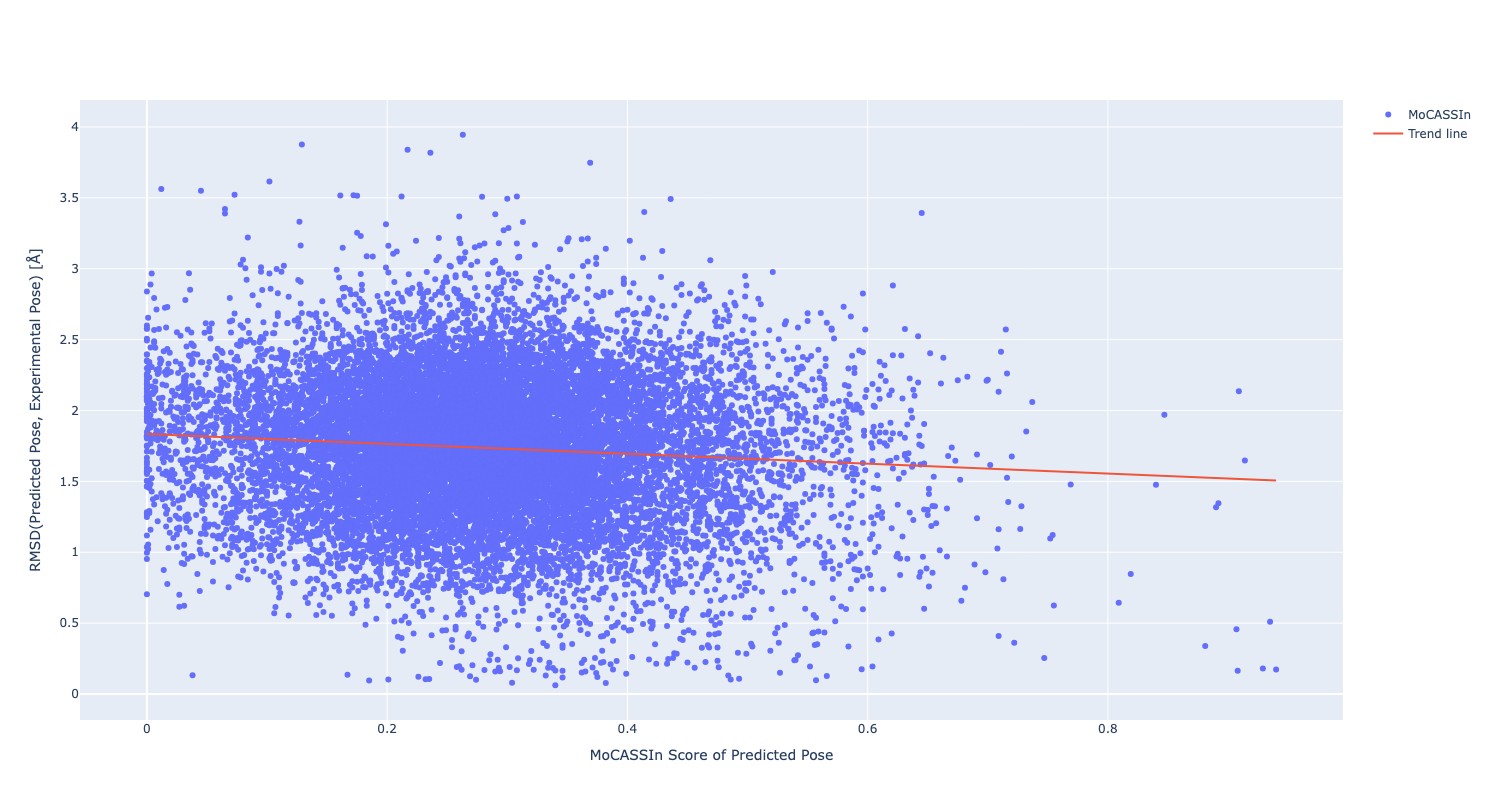

In [137]:
fig = go.Figure()

# Get data
x = df["mocassin_combo(0.95,0.05)"]
y = df["pose_lead_rmsd"]

# Fit linear regression line
coeffs = np.polyfit(x, y, 1)   # degree=1 for linear
poly_eq = np.poly1d(coeffs)

# Create trend line values
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_eq(x_fit)

# Add trend line to the figure
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="MoCASSIn"))
fig.add_trace(go.Scatter(x=x_fit, y=y_fit, mode="lines", name="Trend line"))

fig.update_layout(
    xaxis_title="MoCASSIn Score of Predicted Pose",
    yaxis_title="RMSD(Predicted Pose, Experimental Pose) [Å]",
    width=800,
    height=800,
)

fig

In [139]:
df.to_pickle("A71EV2A_replaced_mocassin.pkl.gz")

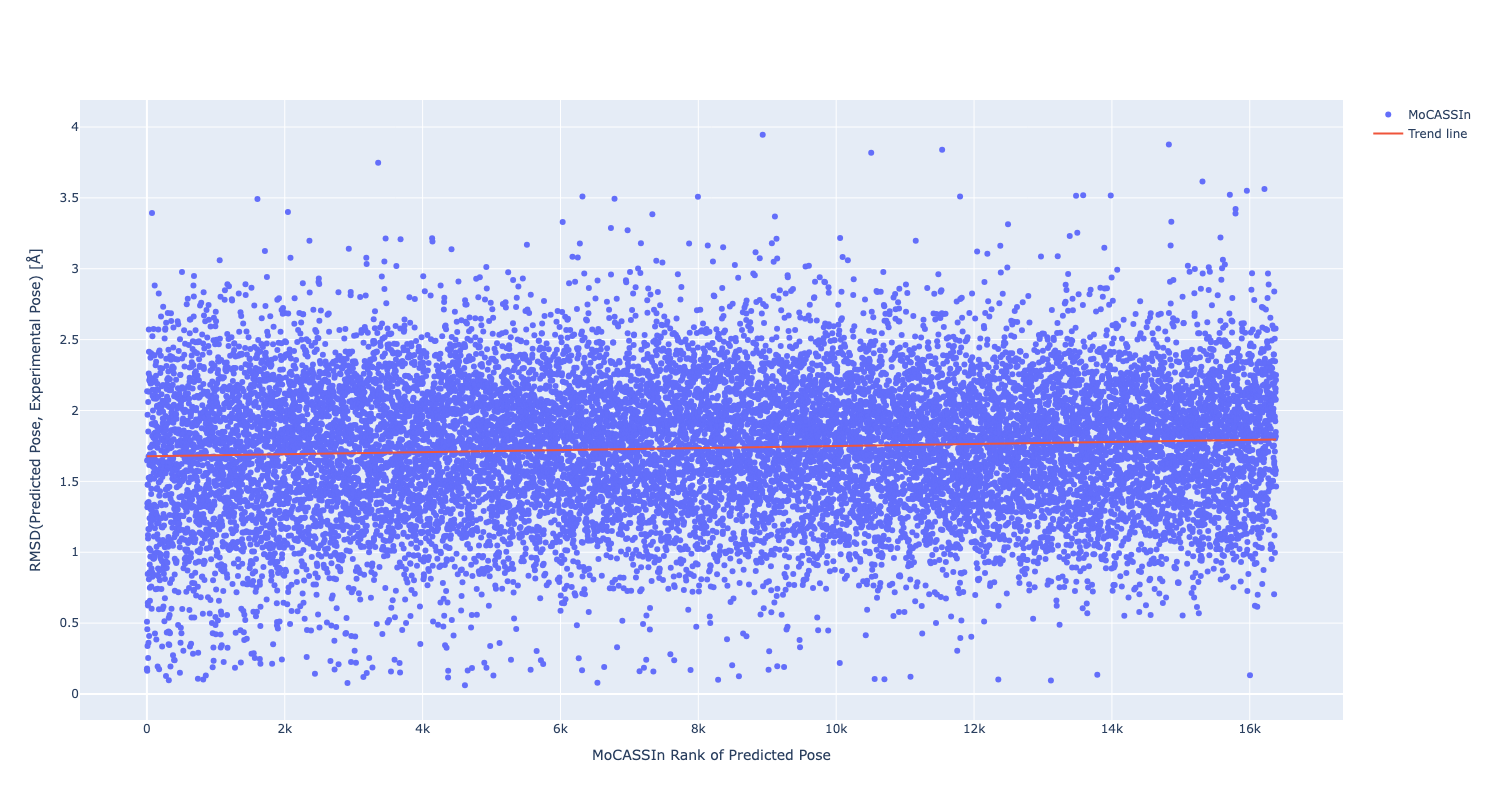

In [146]:
fig = go.Figure()

y = df.sort_values(by="mocassin_combo(0.95,0.05)", ascending=False)["pose_lead_rmsd"]
x = [i for i,y in enumerate(y)]

# Fit linear regression line
coeffs = np.polyfit(x, y, 1)   # degree=1 for linear
poly_eq = np.poly1d(coeffs)

# Create trend line values
x_fit = np.linspace(x[0], x[-1], 100)
y_fit = poly_eq(x_fit)

# Add trend line to the figure
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="MoCASSIn"))
fig.add_trace(go.Scatter(x=x_fit, y=y_fit, mode="lines", name="Trend line"))

fig.update_layout(
    xaxis_title="MoCASSIn Rank of Predicted Pose",
    yaxis_title="RMSD(Predicted Pose, Experimental Pose) [Å]",
    width=800,
    height=800,
)

fig

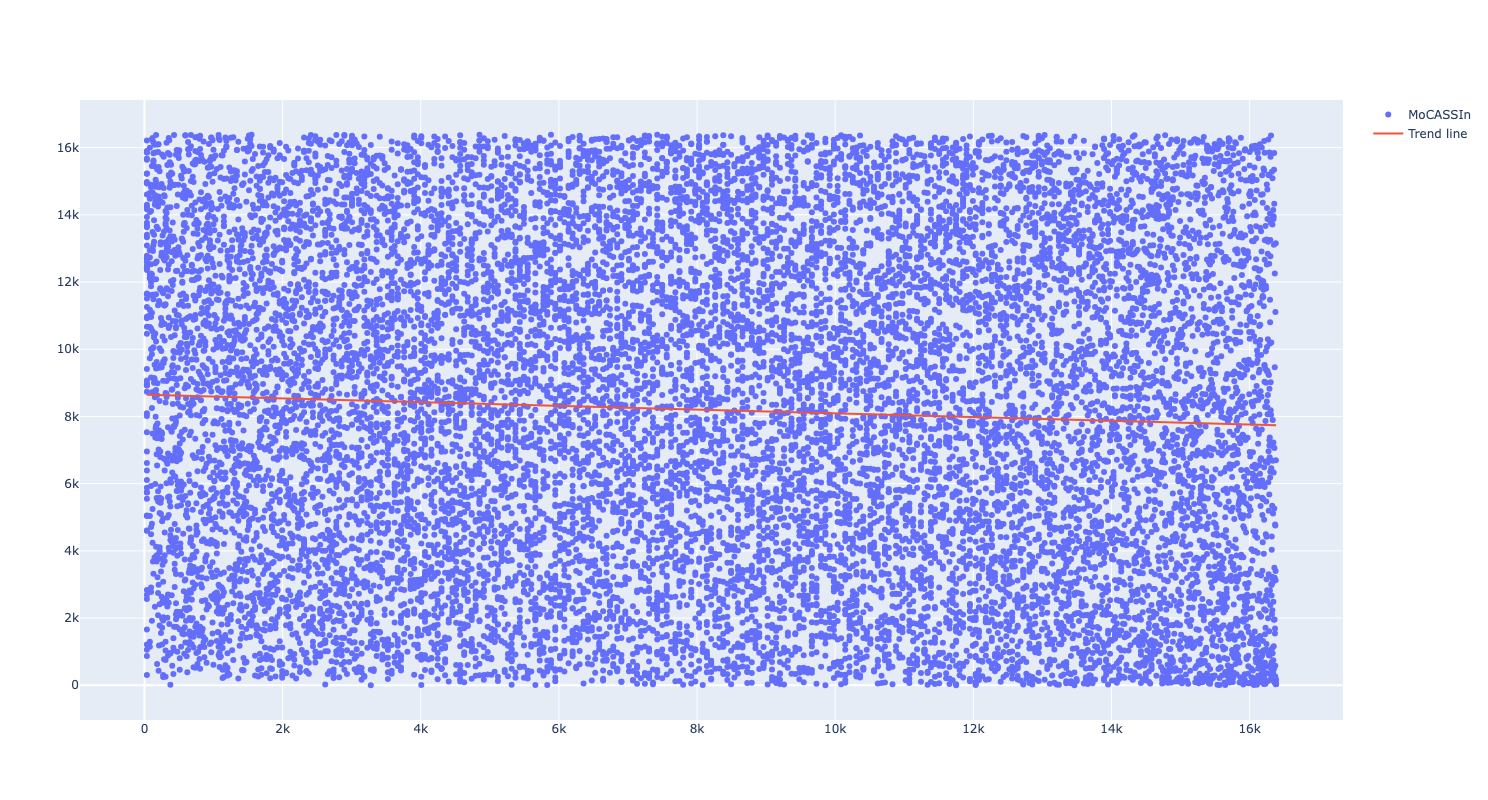

In [150]:
fig = go.Figure()

# Get data
x = df["mocassin_combo(0.95,0.05)"]
y = df["pose_lead_rmsd"]

x = rankdata(x)
y = rankdata(y)

# Fit linear regression line
coeffs = np.polyfit(x, y, 1)   # degree=1 for linear
poly_eq = np.poly1d(coeffs)

# Create trend line values
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_eq(x_fit)

# Add trend line to the figure
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="MoCASSIn"))
fig.add_trace(go.Scatter(x=x_fit, y=y_fit, mode="lines", name="Trend line"))

fig.update_layout(
    # xaxis_title="MoCASSIn Rank of Predicted Pose",
    # yaxis_title="RMSD(Predicted Pose, Experimental Pose) Rank",
    width=800,
    height=800,
)

fig